In [1]:
import numpy as np
import json
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize, Bounds
from datetime import datetime

In [2]:
import wrapper # загружаем солвер

# Решение задачи кустования

In [65]:
with open('info_case1.json') as info_f:
    info = json.load(info_f)
    
CONST_ALPHA = info["CONST"]["CALPHA"] # минимальная длина ребра кустовой площадки
# тыс.руб
CONST_C0 = info["CONST"]["C0"] # стоимость монтажа бурвой площадки
CONST_C1 = info["CONST"]["C1"] # стоимость демонтажа бурвой площадки
CONST_C2 = info["CONST"]["C2"] #стоимость переезда буровой на одной кустовой площадке

# тыс.руб/м
CONST_C3 = info["CONST"]["C3"] #стоимость бурения 1 м

CONST_L = info["CONST"]["CL"] # максимальная длина скважины
CONST_D = info["CONST"]["CD"] # между скважинами

CONST_PENALTY = info["CONST"]["CPENALTY"] # мнодитель штрафа за недопустимые действиея

map_path = info["FILES"]["map"] # карта стоимостей
wells_path = info["FILES"]["wells"] # датасет геологических целей

Загружаем датасет

In [66]:
dem_df = pd.read_csv(map_path, "\t")
wells_df = pd.read_csv(wells_path,sep=';')

In [67]:
dates = wells_df['Date'].apply(lambda x: datetime.strptime(x, '%d.%m.%Y')).unique()
dates.sort()
dates = [pd.Timestamp(d).to_pydatetime().strftime('%d.%m.%Y') for d in dates]
dates

['12.12.2021', '12.06.2022', '12.09.2022', '12.12.2022', '12.12.2023']

Парсим датасет

In [68]:
# load data
nameWell, timeWell, x1Well, y1Well, z1Well, x3Well, y3Well, z3Well, = wrapper.loadWells(wells_df)
xDem, yDem, costDem = wrapper.loadDEM(dem_df)

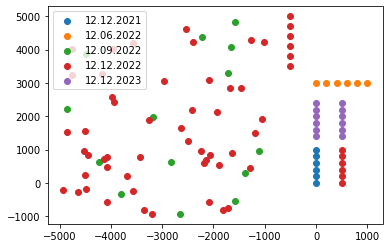

In [69]:
for date in dates:
    X, Y = [x1Well[i] for i in range(len(x1Well)) if timeWell[i].strftime('%d.%m.%Y') == date], [y1Well[i] for i in range(len(y1Well)) if timeWell[i].strftime('%d.%m.%Y') == date]
    plt.scatter(X, Y, label=date)
plt.legend()
plt.show()

Проведем клстеризацию скважин по координатам x1Well и y1Well

In [70]:
nameWell, timeWell, x1Well, y1Well, z1Well, x3Well, y3Well, z3Well, = wrapper.loadWells(wells_df)
xDem, yDem, costDem = wrapper.loadDEM(dem_df)

In [71]:
maxDist = 2000 #задаем максимальное расстояние между кластерами

In [72]:
#вычисляем координаты центров кластеров
space, time = [], []
X = np.zeros((len(x1Well),3))
X[:,0] = x1Well
X[:,1] = y1Well
X[:,2] = z1Well

k = 1
nTry = 1
stop = False
while (not stop):
    stop = True
    for tr in range(nTry):
        kmeans = KMeans(n_clusters=k).fit(X)
        for num, cc in enumerate(kmeans.cluster_centers_):
            dist = np.linalg.norm(X[kmeans.labels_ == num] - cc, axis=1)
            if not np.all(dist < maxDist):
                stop = False
                break
    k = k + 1

for num, cc in enumerate(kmeans.cluster_centers_):
    space.append(X[kmeans.labels_ == num])
for date in dates:
    time.append(X[np.asarray(timeWell) == datetime.strptime(date, '%d.%m.%Y')])
 
xc = kmeans.cluster_centers_[:,0]
yc = kmeans.cluster_centers_[:,1]

4


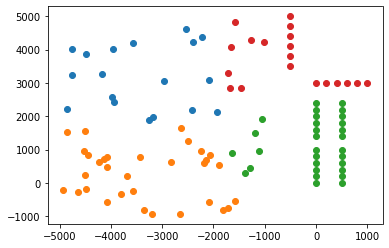

In [73]:
print(len(space))
for X in space:
    plt.scatter(X[:,0],X[:,1])
plt.show()

5


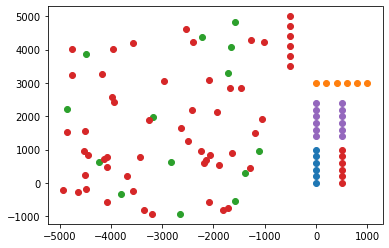

In [74]:
print(len(time))
for X in time:
    plt.scatter(X[:,0], X[:,1])
plt.show()

## Добавляем время в матрицу признаков

In [75]:
X = np.zeros((len(x1Well),3+len(dates)))
X[:,0] = x1Well
X[:,1] = y1Well
X[:,2] = z1Well
for i in range(len(dates)):
    X[:, 3+i] = 1000*(np.asarray(timeWell)==datetime.strptime(dates[i], '%d.%m.%Y')).astype(int)
print(X)

[[    0.     0.  1600.  1000.     0.     0.     0.     0.]
 [    0.   200.  1600.  1000.     0.     0.     0.     0.]
 [    0.   400.  1600.  1000.     0.     0.     0.     0.]
 [    0.   600.  1600.  1000.     0.     0.     0.     0.]
 [    0.   800.  1600.  1000.     0.     0.     0.     0.]
 [    0.  1000.  1600.  1000.     0.     0.     0.     0.]
 [  500.     0.  1600.     0.     0.     0.  1000.     0.]
 [  500.   200.  1600.     0.     0.     0.  1000.     0.]
 [  500.   400.  1600.     0.     0.     0.  1000.     0.]
 [  500.   600.  1600.     0.     0.     0.  1000.     0.]
 [  500.   800.  1600.     0.     0.     0.  1000.     0.]
 [  500.  1000.  1600.     0.     0.     0.  1000.     0.]
 [ -500.  3500.  1600.     0.     0.     0.  1000.     0.]
 [ -500.  3800.  1600.     0.     0.     0.  1000.     0.]
 [ -500.  4100.  1600.     0.     0.     0.  1000.     0.]
 [ -500.  4400.  1600.     0.     0.     0.  1000.     0.]
 [ -500.  4700.  1600.     0.     0.     0.  1000.     0

In [76]:
k = 1
nTry = 1
stop = False
while (not stop):
    stop = True
    for tr in range(nTry):
        kmeans = KMeans(n_clusters=k).fit(X)
        for num, cc in enumerate(kmeans.cluster_centers_):
            dist = np.linalg.norm(X[kmeans.labels_ == num] - cc, axis=1)
            if not np.all(dist < maxDist):
                stop = False
                break
    k = k + 1

xc = kmeans.cluster_centers_[:,0]
yc = kmeans.cluster_centers_[:,1]

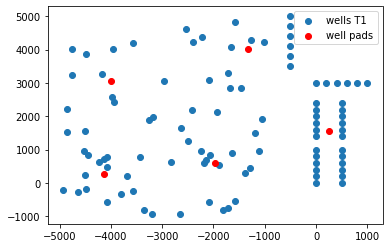

In [77]:
plt.scatter(X[:,0],X[:,1], label='wells T1')
plt.scatter(xc, yc, c='r', label='well pads')
plt.legend()
plt.show()

In [78]:
a = wrapper.Answer()
for well_index, well_pad_id in enumerate(kmeans.labels_):
    a.add_single_well(xc[well_pad_id], yc[well_pad_id], nameWell[well_index])
answer_json = a.export

In [79]:
#построим решение
verbose_solution = 1 #распечатаем лог решения
solution = wrapper.Solution(dem_df, wells_df, answer_json, CONST_ALPHA, CONST_C0, CONST_C1, CONST_C2, CONST_C3, CONST_L, CONST_D, CONST_PENALTY)

In [80]:
solution.cost

82755126928584.02

In [81]:
#узнаем, удовлетворяет ли оно ограничениями (True - удовлетворяет, False - не удовлетворяет)
solution.status

False

In [83]:
solution.save_answer('1.json')

D:\study\hackaton forum\Описание задачи _Кустование_\case1\wrapper.py:351: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  sc = plt.pcolormesh(self.X, self.Y, np.log(self.K), cmap=cmap)


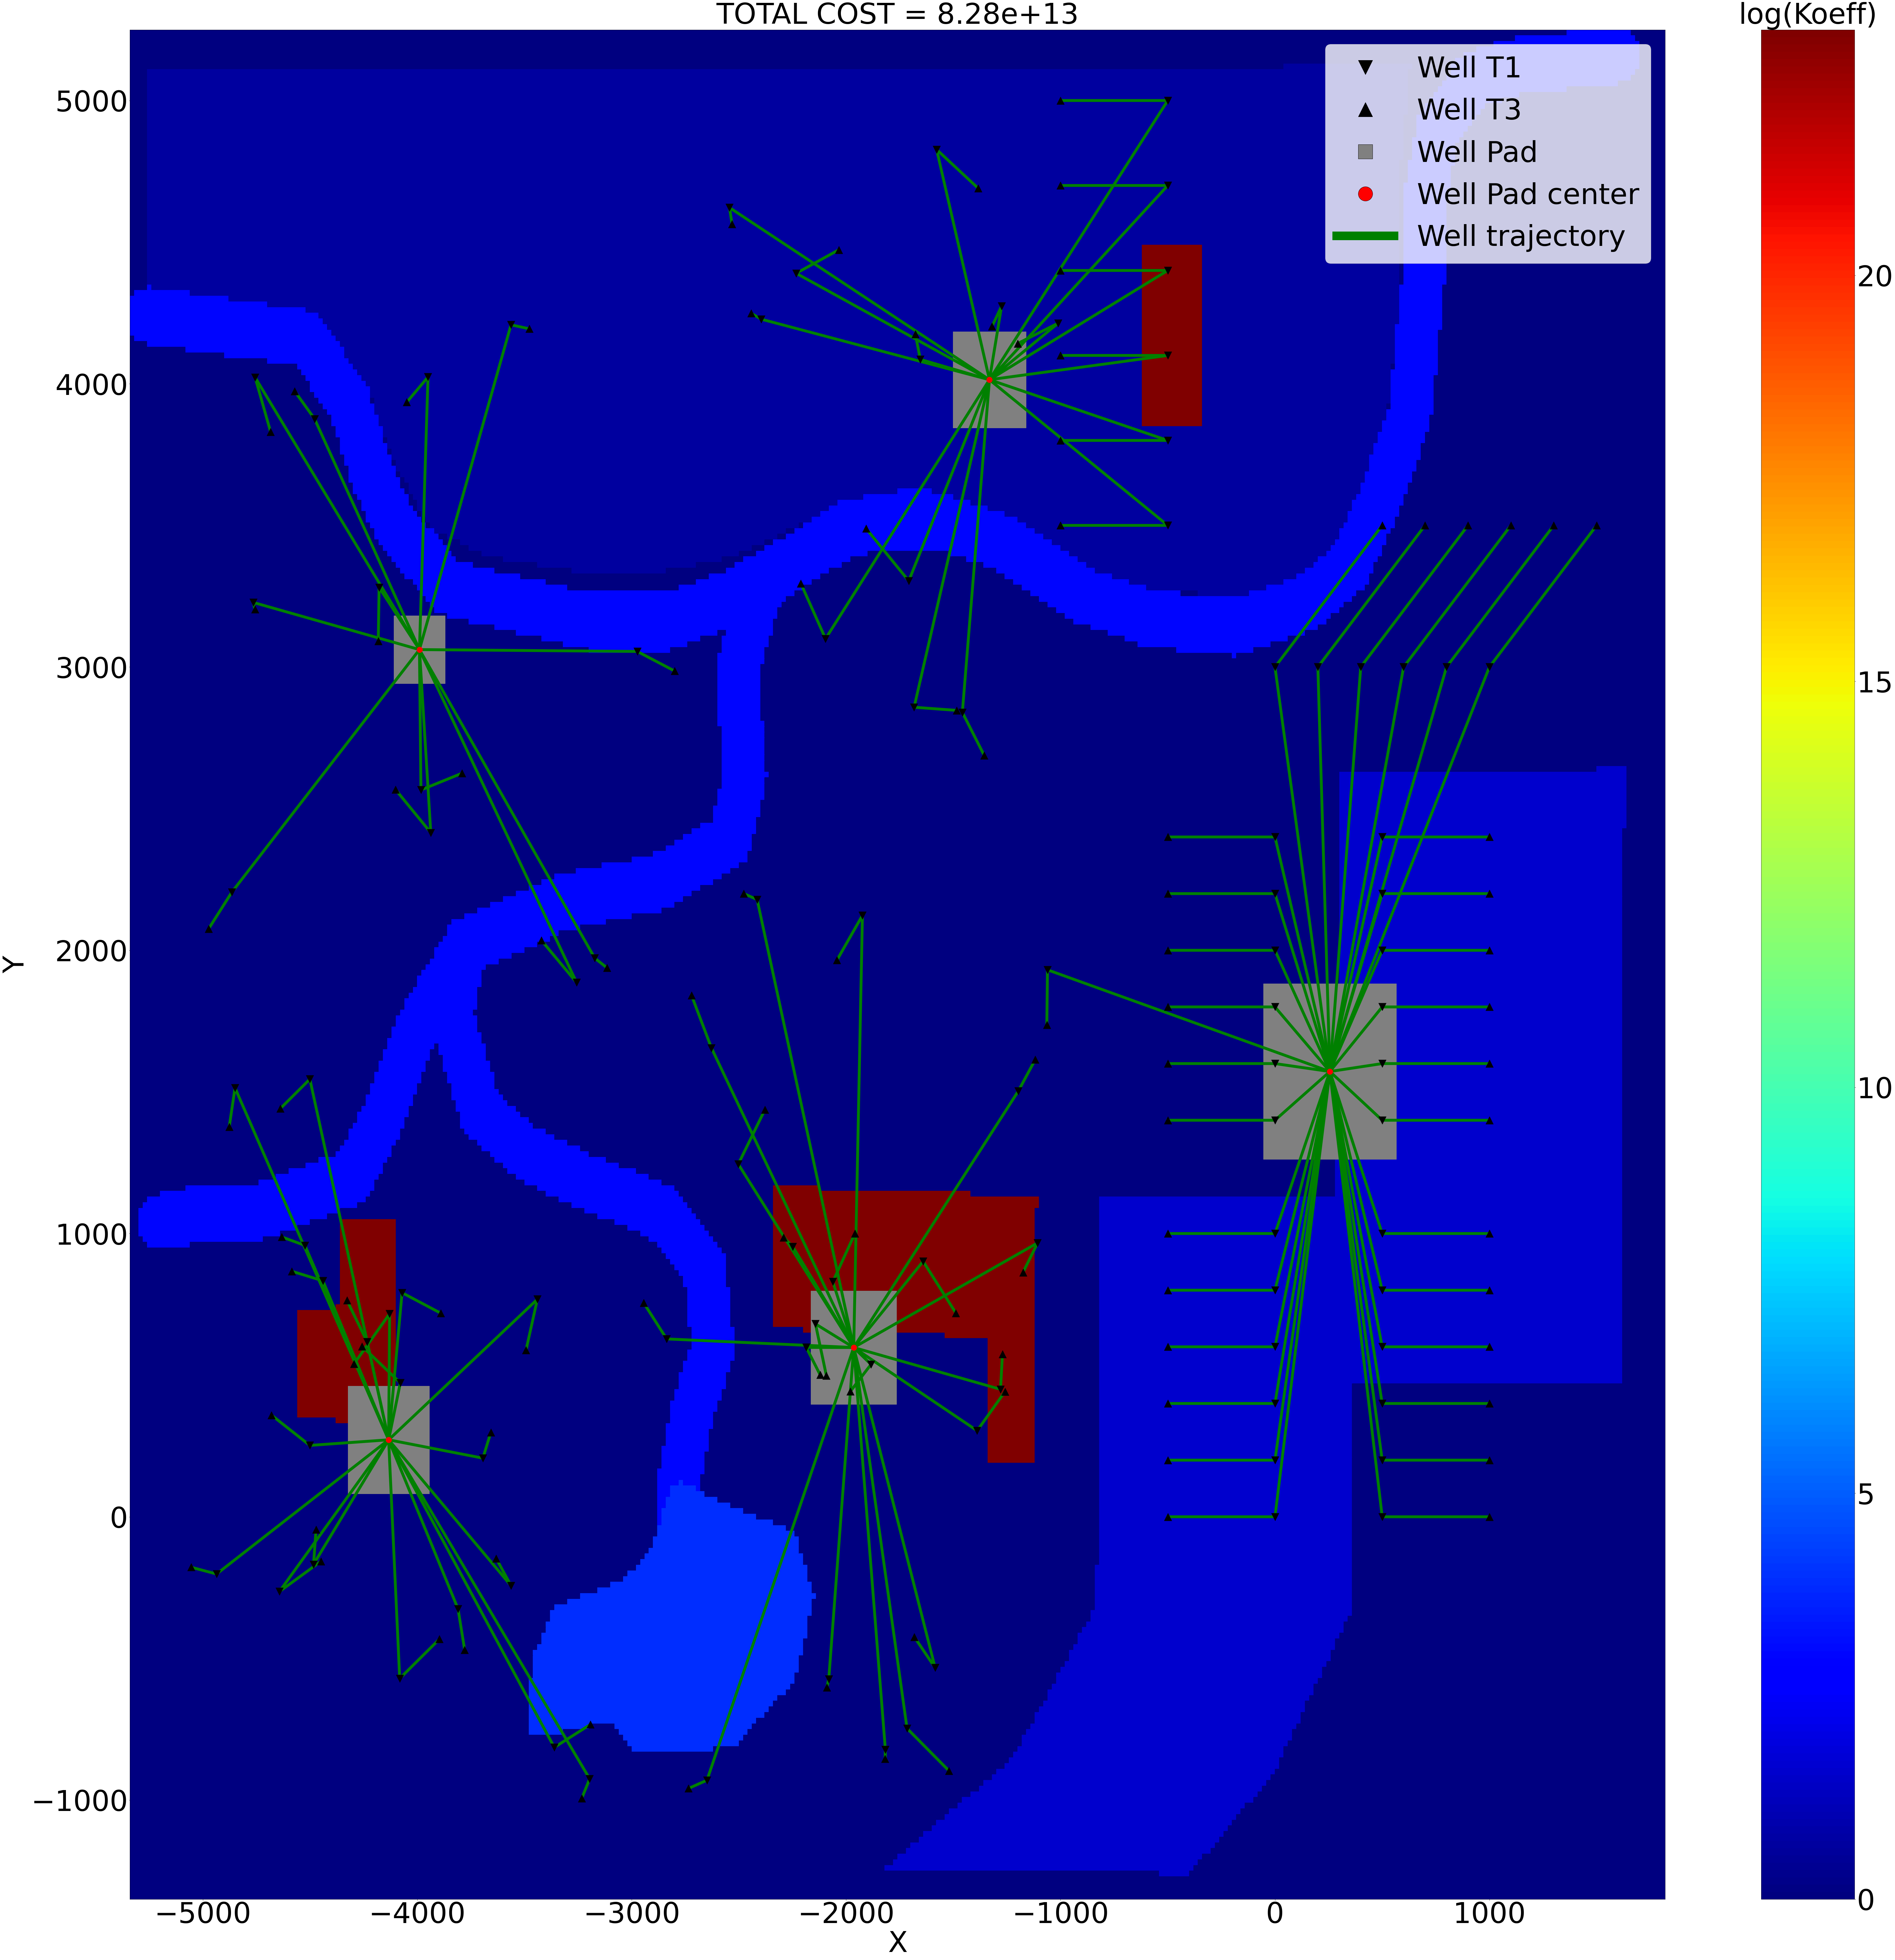

In [84]:
#посмотрим графический вариант решения 
solution.plot()

In [85]:
#сохраняем графический вариант решения в файл solution.png
solution.save_plot('solution.png')

Построим оптимизационную задачу, чтобы определить координаты скважин

In [86]:
#напишем функции, которая позволит преобразовывать вектор координат x в координаты кустов скважин
def solve(x):
    a = wrapper.Answer()
    for well_index, well_pad_id in enumerate(kmeans.labels_):
        a.add_single_well(x[2*well_pad_id], x[2*well_pad_id+1], nameWell[well_index])
    
    answer_json = a.export
    
    solution = wrapper.Solution(dem_df, wells_df, answer_json, CONST_ALPHA, CONST_C0, CONST_C1, CONST_C2, CONST_C3, CONST_L, CONST_D, CONST_PENALTY)
    return solution

def f(x_initial):
    current_cost = solve(x_initial).cost
    return current_cost

In [87]:
# начальная догадка для вектора варьируемых параметров (координат центров)
x_init = np.array([int(item) for sublist in kmeans.cluster_centers_[:,0:2] for item in sublist])

## Используем алгоритм имитации отжига для минимизации решения

In [88]:
from copy import deepcopy

def neighbors(x):
    for i in range(len(x)):
        x[i] += 100
        yield deepcopy(x)
        x[i] -= 200
        yield deepcopy(x)
        x[i] += 100

In [89]:
from tqdm import tqdm
import random
import scipy.stats as st
import math

def simulated_annealing(start, neighbors, target, m, T):
    '''
    Реализация алгоритма имитации отжига
    start - начальный элемент
    neighbors - генератор соседей
    target - функция, которую мы минимизируем
    m - количество итераций
    '''
    s = start
    t = target(s)
    n_iter = 1
    td = dict()
    td[tuple(s)] = t
    t_hist = []
    for i in tqdm(list(range(m))):
        stop = True
        s_new = random.choice(list(neighbors(s)))
        if tuple(s_new) not in td:
            t_new = target(s_new)
            n_iter += 1
            td[tuple(s_new)] = t_new
        else:
            t_new = td[tuple(s_new)]
        r = st.uniform.rvs()
        if t_new < t or (r < np.exp((t - t_new)*(i+1)/T)):
            s = s_new
            t = t_new
        t_hist.append(t)
    return s, t_hist, n_iter

In [119]:
%%time
res, t_hist, n_iter = simulated_annealing(x_init, neighbors, f, 200, 1)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:30<00:00,  2.22it/s]

Wall time: 1min 30s


In [141]:
res

array([-3989.,  3061.,   -44.,  1571., -4133.,    71., -1331.,  4014.,
       -2064.,   397.])

In [131]:
# Количество вызовов функции
n_iter

110

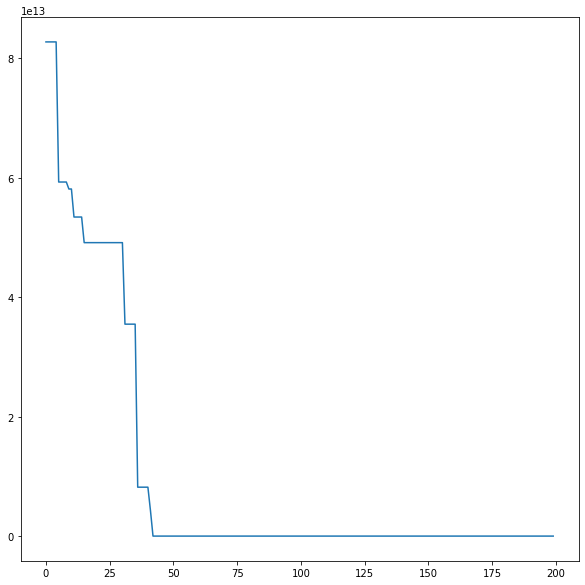

In [132]:
# Сходимость оптимизации
plt.figure(figsize=(10,10))
plt.plot(t_hist)

In [133]:
res = res.astype(float)

In [134]:
#построим решение с координатами кустов, полученных из оптимизатора и сохраним его результат в файл answer.csv
best_solution = solve(x=res)

In [135]:
#узнаем, удовлетворяет ли оно ограничениями (True - удовлетворяет, False - не удовлетворяет)
best_solution.status

True

In [136]:
best_solution.cost

2255611.5134294

In [137]:
#сохраним решение в файл answer.json
best_solution.save_answer('answer_1.json')

D:\study\hackaton forum\Описание задачи _Кустование_\case1\wrapper.py:351: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  sc = plt.pcolormesh(self.X, self.Y, np.log(self.K), cmap=cmap)


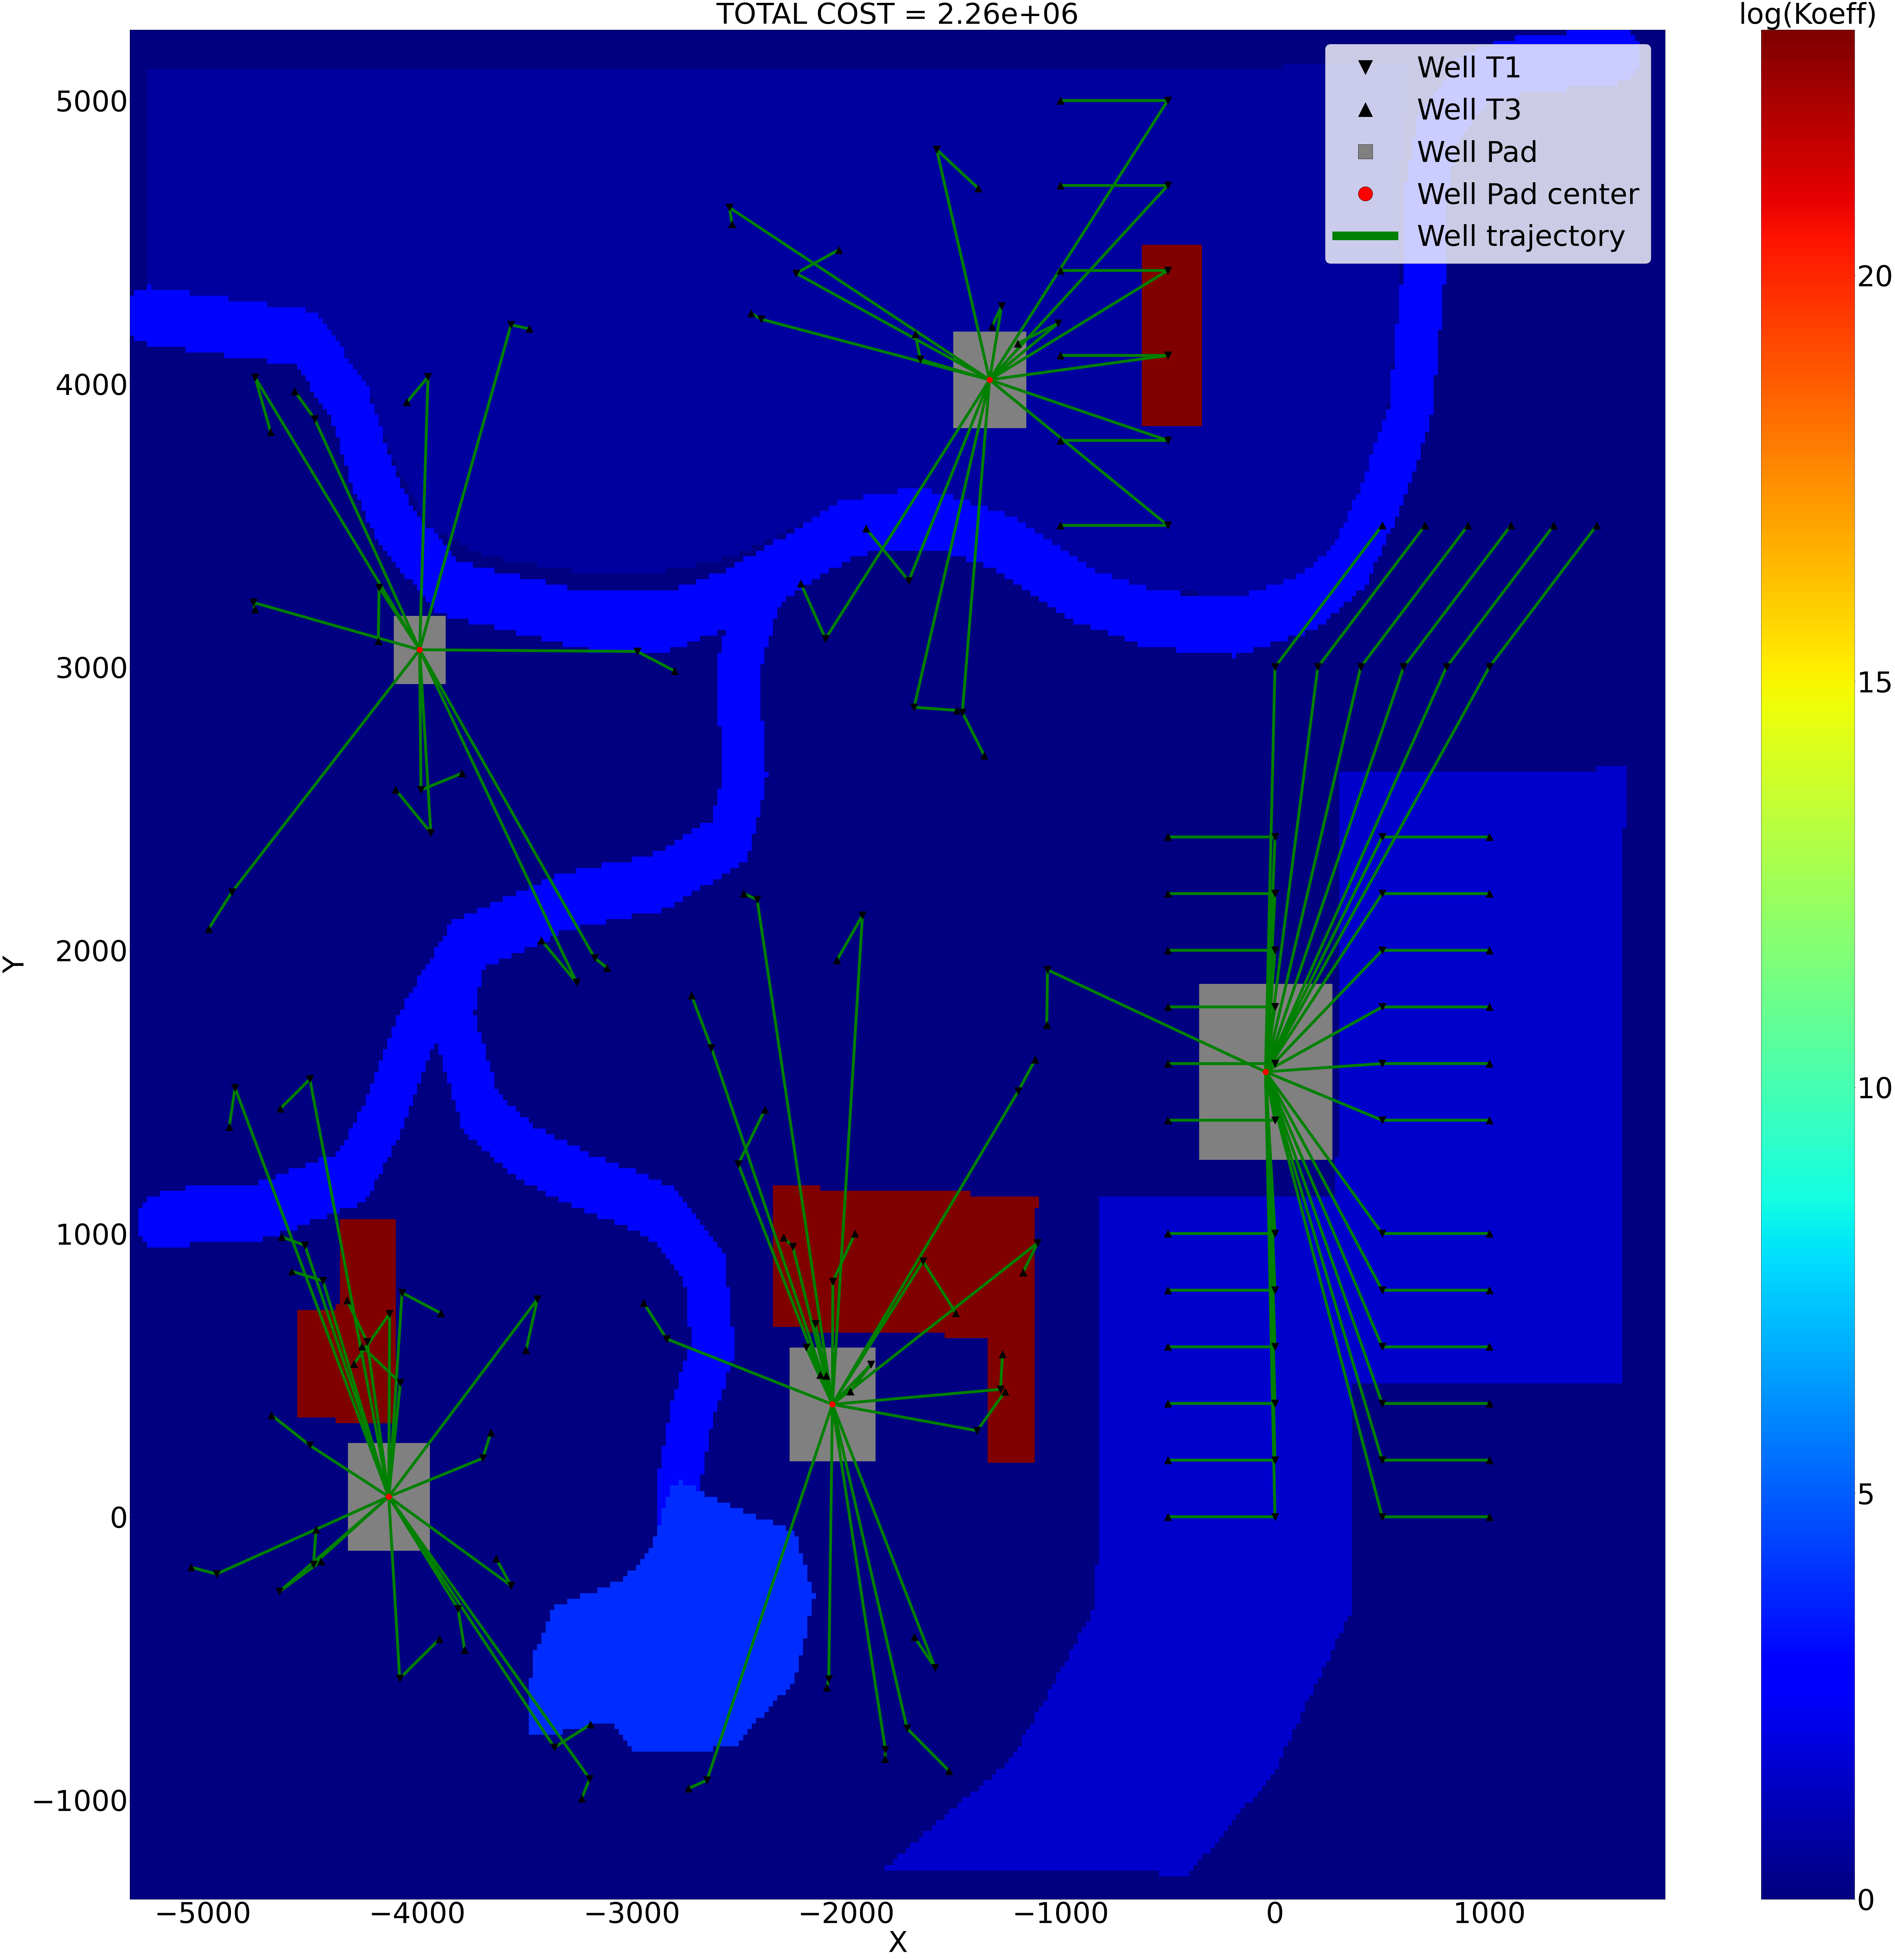

In [138]:
best_solution.plot()

In [139]:
best_solution.save_plot('solution2.png')